# Flux Power-spectrum :

In [6]:
import numpy as np
import h5py 
import os
import matplotlib.pyplot as plt
plt.style.use('Notebook.mystyle')
plt.style.use('tableau-colorblind10')
import lytomo_watershed
from lytomo_watershed import spectra_mocking as sm
data_dir = '/run/media/mahdi/HD2/Lya/LyTomo_data/'

In [2]:
def plot_power_spec(ax, kf, kf_FGPA, mean_flux_power, mean_flux_power_FGPA):
    import os
    ax[0].plot(kf, mean_flux_power*kf/np.pi, label='Hydro', ls='--') 
    ax[0].plot(kf_FGPA, mean_flux_power_FGPA*kf_FGPA/np.pi, label='FGPA', ls='dotted') 
    boss = np.loadtxt(os.path.join(data_dir,'plotting_data/power_spec_boss_z2.6.dat'))
    ax[0].plot(boss[:,0],boss[:,1], linewidth=4, label='BOSS 2.6')
    boss = np.loadtxt(os.path.join(data_dir,'plotting_data/power_spec_boss_z2.4.dat'))
    ax[0].plot(boss[:,0],boss[:,1], linewidth=4, label='BOSS 2.4')
    
    ax[0].set_xscale('log')
    ax[0].set_yscale('log')
    ax[0].set_xlabel('k (s/km)')
    ax[0].set_ylabel(r'$\mathrm{p(k) \times k / \pi}$')
    ax[0].legend()
    ax[0].set_ylim(1e-3,1e-1)
    
    # Plot the ratios
    k = np.arange(boss[0,0], boss[-1,0],kf[1]-kf[0])
    
    boss_power_interp = np.interp(k, boss[:,0], boss[:,1])
    mean_flux_power_interp = np.interp(k, kf, mean_flux_power*kf/np.pi)
    mean_flux_power_FGPA_interp = np.interp(k, kf_FGPA, mean_flux_power_FGPA*kf_FGPA/np.pi)
    
    ax[1].plot(k, mean_flux_power_interp/boss_power_interp, label='Hydro', ls='--')
    ax[1].plot(k, mean_flux_power_FGPA_interp/boss_power_interp, label='FGPA', ls='dotted')
    ax[1].legend()
    ax[1].set_xscale('log')
    ax[1].set_ylabel('P_sim / P_BOSS')
    ax[1].set_ylim(0.1,1.5)

In [4]:
def compare_power_spectrum():
    from fake_spectra import fluxstatistics as fs        
    from scipy.ndimage import gaussian_filter1d as gf
    import os
    vmax = 21725
    with h5py.File(os.path.join(data_dir,'spectra_z2.4/spectra_TNG_true_1.0_z2.4.hdf5'), 'r') as f:
        tau = gf(f['tau/H/1/1215'][:], 1, mode='wrap')
        z = f['Header'].attrs['redshift']
    spec_res = vmax/tau.shape[1]
    kf, mean_flux_power = fs.flux_power(tau, vmax= vmax, spec_res= spec_res,
                                        mean_flux_desired=sm.get_mean_flux(z=z))
    with h5py.File(os.path.join(data_dir,'FGPA/spectra_FGPA_z2.4_1.0.hdf5'), 'r') as f:
        tau = gf(f['tau/H/1/1215'][:], 1, mode='wrap')
    spec_res = vmax/tau.shape[1]
    kf_FGPA, mean_flux_power_FGPA = fs.flux_power(tau, vmax= vmax, spec_res= spec_res,
                                                  mean_flux_desired=sm.get_mean_flux(z=z))
    print(sm.get_mean_flux(z=z))
    
    fig, ax = plt.subplots(1,2, figsize=(20,10))
    plot_power_spec(ax, kf, kf_FGPA, mean_flux_power, mean_flux_power_FGPA)

findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans.


0.8103939195906893


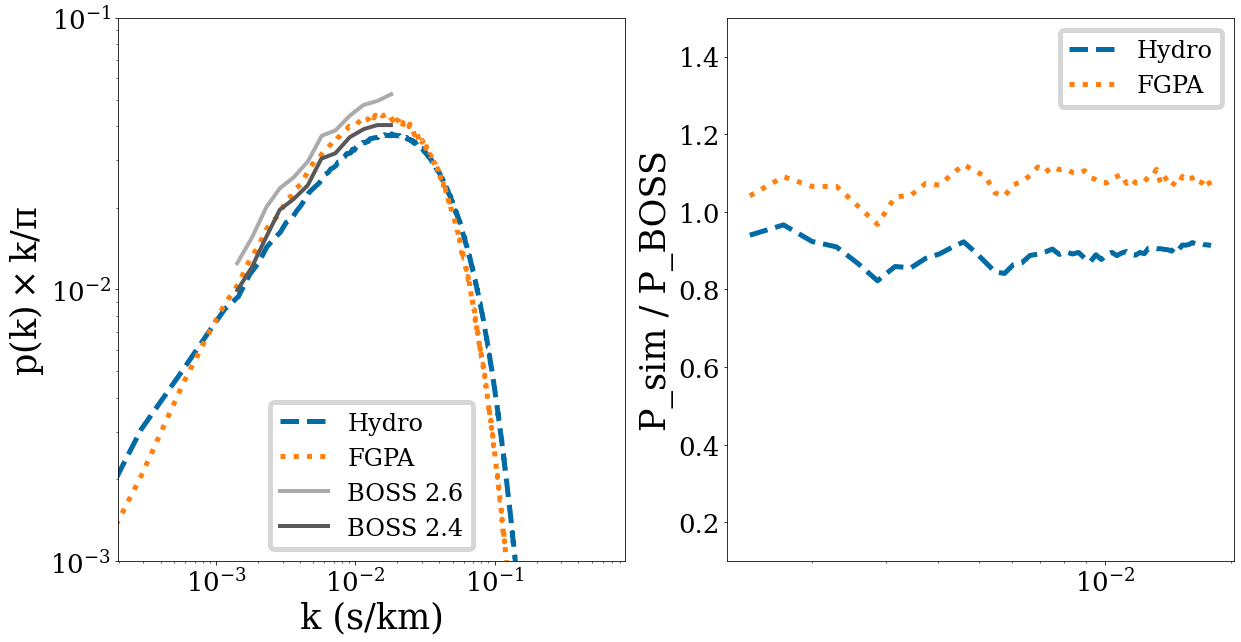

In [15]:
compare_power_spectrum()

Main questions : 

- [ ] Why power is missed on large sacles for FGPA ? Figure 7 in [Sorini 2016](https://arxiv.org/pdf/1602.08099.pdf) shows a good agreement between GS+FGPA and Hydro on large scales $k \sim 10^{-2} \ s/km$, they have $ \sim 10 \% $ error, but ours has $\sim 30 \%$.

- The Hydro's power spectrum improves if we slightly change the mean flux by 0.01 . This is equivalant to change of redshift from 2.45 to 2.50 much smaller than BOSS redshift precision. So the power spectrum of Hydro is fine.

-  For FGPA: Lowering the mean flux makes it closer to BOSS with their Ks.

In [5]:
import codes.spectra_mocking as sm
print(sm.get_mean_flux(z=2.44))
print(sm.get_mean_flux(z=2.5))

0.8112485153325563
0.798894980616534


## Match Hydro and FGPA to BOSS :

Find the optimal mean flux for which the Hydro and FGPA power spectrum mathces with BOSS data :

(      fun: 7.933485398507811e-07
  hess_inv: array([[16.94642542]])
       jac: array([1.1810524e-06])
   message: 'Optimization terminated successfully.'
      nfev: 40
       nit: 3
      njev: 20
    status: 0
   success: True
         x: array([0.79306663]),
       fun: 6.920525099289801e-07
  hess_inv: array([[13.13645633]])
       jac: array([-2.48315523e-07])
   message: 'Optimization terminated successfully.'
      nfev: 10
       nit: 3
      njev: 5
    status: 0
   success: True
         x: array([0.82110785]))

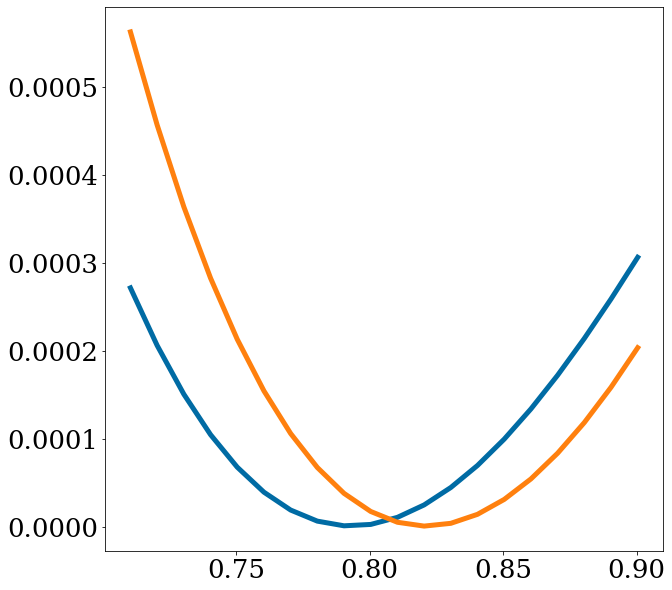

In [17]:
def optimal_mean_flux(plot_loss=True):
    """Convergence with number of spectra averaged over"""
    from fake_spectra import fluxstatistics as fs
    from scipy.ndimage import gaussian_filter1d as gf
    import scipy.optimize
    from scipy.optimize import minimize
    import os

    vmax = 21725
    with h5py.File(os.path.join(data_dir,'spectra_z2.4/spectra_TNG_true_1.0_z2.4.hdf5'), 'r') as f:
        tau_hydro = gf(f['tau/H/1/1215'][:], 1, mode='wrap')
        z = f['Header'].attrs['redshift']
    spec_res_h = vmax/tau_hydro.shape[1]  
    with h5py.File('/run/media/mahdi/HD2/simulations/TNG300-1/postprocessing/FGPA/densfield/spectra_FGPA_z2.4_1.0.hdf5', 'r') as f:
        tau_fgpa = gf(f['tau/H/1/1215'][:], 1, mode='wrap')
    spec_res_f = vmax/tau_fgpa.shape[1]
    
    boss = np.loadtxt(os.path.join(data_dir,'plotting_data/power_spec_boss_z2.4.dat'))
    def distance(x, tau, vmax, spec_res):
        kf, mean_flux_power = fs.flux_power(tau=tau, vmax= vmax, spec_res= spec_res, 
                                        mean_flux_desired=x)
        mean_flux_power_interp = np.interp(boss[:,0], kf, mean_flux_power)
        diff = boss[:,0]*mean_flux_power_interp/np.pi - boss[:,1]
        return np.dot(diff,diff)/diff.size
    MF_fit_hydro = minimize(fun=distance, x0 = sm.get_mean_flux(z=z),
                            args=(tau_hydro,vmax,spec_res_h))
    MF_fit_fgpa = minimize(fun=distance, x0 = sm.get_mean_flux(z=z),
                           args=(tau_fgpa,vmax,spec_res_f))
    if plot_loss :
        mf = np.arange(sm.get_mean_flux(z=z)-0.1, sm.get_mean_flux(z=z)+0.1, 0.01)
        dis = []
        for m in mf:
            dis.append(distance(x=m, tau=tau_hydro, vmax=vmax, spec_res=spec_res_h))
        plt.plot(mf, dis)
        dis = []
        for m in mf:
            dis.append(distance(x=m, tau=tau_fgpa, vmax=vmax, spec_res=spec_res_f))
        plt.plot(mf, dis)
        
    return MF_fit_hydro, MF_fit_fgpa

optimal_mean_flux(plot_loss=True)

In [7]:
print( 'For Hydro, the mean flux variation = ',  
      sm.get_mean_flux(z=2.4442257045541464) - 0.7941)
print( 'For FGPA, the mean flux variation = ',  
      sm.get_mean_flux(z=2.4442257045541464) - 0.732)

For Hydro, the mean flux variation =  0.016293919590689265
For FGPA, the mean flux variation =  0.07839391959068931


## Final takeaway :
The plos above show the FGPA spectra with no initial smoothing applied on desnity and velocity recovers the power spectrum by $\pm 20 \%$ within $k = [10^{-3} , 5\times 10^{-2} \ s/km]$. It is in agreement with what [Sorini 2016](https://iopscience.iop.org/article/10.3847/0004-637X/827/2/97/pdf) found.


## Convergence test :

Convergence with number of spectra averaged over

findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans.


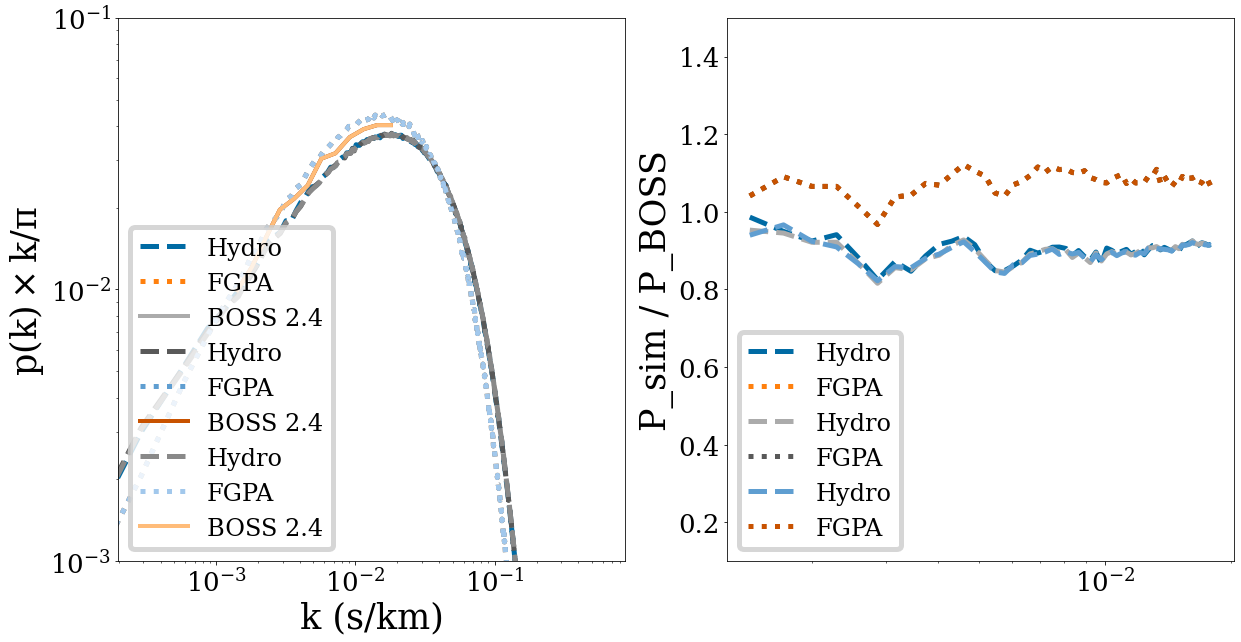

In [7]:
def plot_power_spec(ax, kf, kf_FGPA, mean_flux_power, mean_flux_power_FGPA):
    """Convergence with number of spectra averaged over"""
    ax[0].plot(kf, mean_flux_power*kf/np.pi, label='Hydro', ls='--') 
    ax[0].plot(kf_FGPA, mean_flux_power_FGPA*kf_FGPA/np.pi, label='FGPA', ls='dotted') 
    boss = np.loadtxt(os.path.join(data_dir,'plotting_data/power_spec_boss_z2.4.dat'))
    ax[0].plot(boss[:,0],boss[:,1], linewidth=4, label='BOSS 2.4')
    
    ax[0].set_xscale('log')
    ax[0].set_yscale('log')
    ax[0].set_xlabel('k (s/km)')
    ax[0].set_ylabel(r'$\mathrm{p(k) \times k / \pi}$')
    ax[0].legend()
    ax[0].set_ylim(1e-3,1e-1)
    
    # Plot the ratios
    k = np.arange(boss[0,0], boss[-1,0],kf[1]-kf[0])
    
    boss_power_interp = np.interp(k, boss[:,0], boss[:,1])
    mean_flux_power_interp = np.interp(k, kf, mean_flux_power*kf/np.pi)
    mean_flux_power_FGPA_interp = np.interp(k, kf_FGPA, mean_flux_power_FGPA*kf_FGPA/np.pi)
    
    ax[1].plot(k, mean_flux_power_interp/boss_power_interp, label='Hydro', ls='--')
    ax[1].plot(k, mean_flux_power_FGPA_interp/boss_power_interp, label='FGPA', ls='dotted')
    ax[1].legend()
    ax[1].set_xscale('log')
    ax[1].set_ylabel('P_sim / P_BOSS')
    ax[1].set_ylim(0.1,1.5)

def convergence_test():
    """Convergence with number of spectra averaged over"""
    from fake_spectra import fluxstatistics as fs        
    from scipy.ndimage import gaussian_filter1d as gf
    vmax = 21725
    with h5py.File(os.path.join(data_dir,'spectra_z2.4/spectra_TNG_true_1.0_z2.4.hdf5'), 'r') as f:
        tau_hydro = gf(f['tau/H/1/1215'][:], 1, mode='wrap')
        z = f['Header'].attrs['redshift']
    spec_res_h = vmax/tau_hydro.shape[1]
    with h5py.File(os.path.join(data_dir,'FGPA/spectra_FGPA_z2.4_1.0.hdf5'), 'r') as f:
        tau_fgpa = gf(f['tau/H/1/1215'][:], 1, mode='wrap')
    spec_res_f = vmax/tau_fgpa.shape[1]
    
    num_spec = tau_hydro.shape[0]*np.array([0.5, 0.8, 1.0])
    fig, ax = plt.subplots(1,2, figsize=(20,10))
    
    for i in num_spec.astype(int):
        kf, mean_flux_power = fs.flux_power(tau_hydro[0:i,:], vmax= vmax,
                                            spec_res= spec_res_h, 
                                            mean_flux_desired=sm.get_mean_flux(z=z))
        kf_FGPA, mean_flux_power_FGPA = fs.flux_power(tau_fgpa[0:i,:], vmax= vmax,
                                                      spec_res= spec_res_f,
                                                      mean_flux_desired=sm.get_mean_flux(z=z))
        plot_power_spec(ax, kf, kf_FGPA, mean_flux_power, mean_flux_power_FGPA)
    
convergence_test()    